# Model 200 BasicVs: Coupled Steady-State Solution

This model shows example usage of the Basic model from the TerrainBento package.

The BasicVs model implements modifies Basic to use variable source area runoff using the ''effective area'' approach:

$\frac{\partial \eta}{\partial t} = - KA_{eff}^{1/2}S + D\nabla^2 \eta$

where

$A_{eff} = A e^{-\alpha S / A}$

Refer to [REF MANUSCRIPT] for the definition of all symbols. 

This notebook (a) shows the initialization and running of this model, (b) saves a NetCDF file of the topography, which we will use to make an oblique Paraview image of the landscape, and (c) creates a slope-area plot at steady state.

In [1]:
# import required modules
import os
import numpy as np

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({'font.size': 20})
%matplotlib inline

from landlab import imshow_grid
from landlab.io.netcdf import write_netcdf

from terrainbento import BasicVs

In [2]:
# create the parameter dictionary needed to instantiate the model 
# all parameters used are specified in this notebook block

params = {'number_of_node_rows' : 100,
          'number_of_node_columns' : 160,
          'node_spacing' : 10.0,
          'east_boundary_closed' : False,
          'north_boundary_closed' : False,
          'west_boundary_closed' : False,
          'south_boundary_closed' : False,
          'dt' : 10.0,
          'K_sp' : 0.001,
          'm_sp' : 0.5,
          'n_sp' : 1.0,
          'linear_diffusivity' : 0.1,
          'outlet_lowering_rate' : 0.0005,
          'output_filename': 'model_000_output',
          'recharge_rate': 0.01,
          'initial_soil_thickness' : 1.0,
          'K_hydraulic_conductivity' : 15.
}

In [3]:
# initialize the model by passing the parameter dictionary
model = BasicVs(params=params)

# set a tolerance for determining steady state
tolerance = 0.0001

In [4]:
# run the model, it will take 1,490,000 years

# set dt and initialize the elapsed_time variable
dt = params['dt']
elapsed_time = 0 

# initialize a variable to identify if steady state has been reached
keep_running = True

# run the model until stead state has been reached. 
while keep_running == True:
    
    # save the pre-model-step topography of the core nodes to assess steady state. 
    pre_topo = model.grid.at_node['topographic__elevation'][model.grid.core_nodes]
    
    # run the model one step
    model.run_one_step(dt)
    
    # save the post-model step topography of the core nodes to assess steady state. 
    post_topo = model.grid.at_node['topographic__elevation'][model.grid.core_nodes]
    
    # increment elapsed time
    elapsed_time += dt
    
    # assess if steady state has been reached. 
    if max(abs(pre_topo - post_topo)) <= tolerance: # 1 mm
        keep_running = False
    
    # if time rounds to 10,000 years, print out a log message. 
    if elapsed_time % 10000 == 0:
        print('Elapsed time: ', elapsed_time)
        print('Maximum Topographic Change/Tolerance: ', np.round(max(abs(pre_topo - post_topo))/tolerance, decimals=2))       

Elapsed time:  10000.0
Maximum Topographic Change/Tolerance:  49.82
Elapsed time:  20000.0
Maximum Topographic Change/Tolerance:  57.0
Elapsed time:  30000.0
Maximum Topographic Change/Tolerance:  74.59
Elapsed time:  40000.0
Maximum Topographic Change/Tolerance:  120.72
Elapsed time:  50000.0
Maximum Topographic Change/Tolerance:  151.13
Elapsed time:  60000.0
Maximum Topographic Change/Tolerance:  77.58
Elapsed time:  70000.0
Maximum Topographic Change/Tolerance:  156.46
Elapsed time:  80000.0
Maximum Topographic Change/Tolerance:  94.91
Elapsed time:  90000.0
Maximum Topographic Change/Tolerance:  55.98
Elapsed time:  100000.0
Maximum Topographic Change/Tolerance:  55.95
Elapsed time:  110000.0
Maximum Topographic Change/Tolerance:  77.62
Elapsed time:  120000.0
Maximum Topographic Change/Tolerance:  63.97
Elapsed time:  130000.0
Maximum Topographic Change/Tolerance:  50.7
Elapsed time:  140000.0
Maximum Topographic Change/Tolerance:  100.94
Elapsed time:  150000.0
Maximum Topograph

Elapsed time:  1200000.0
Maximum Topographic Change/Tolerance:  50.5
Elapsed time:  1210000.0
Maximum Topographic Change/Tolerance:  16.9
Elapsed time:  1220000.0
Maximum Topographic Change/Tolerance:  37.36
Elapsed time:  1230000.0
Maximum Topographic Change/Tolerance:  55.74
Elapsed time:  1240000.0
Maximum Topographic Change/Tolerance:  36.56
Elapsed time:  1250000.0
Maximum Topographic Change/Tolerance:  39.39
Elapsed time:  1260000.0
Maximum Topographic Change/Tolerance:  79.74
Elapsed time:  1270000.0
Maximum Topographic Change/Tolerance:  66.4
Elapsed time:  1280000.0
Maximum Topographic Change/Tolerance:  29.63
Elapsed time:  1290000.0
Maximum Topographic Change/Tolerance:  82.02
Elapsed time:  1300000.0
Maximum Topographic Change/Tolerance:  93.83
Elapsed time:  1310000.0
Maximum Topographic Change/Tolerance:  15.3
Elapsed time:  1320000.0
Maximum Topographic Change/Tolerance:  29.99
Elapsed time:  1330000.0
Maximum Topographic Change/Tolerance:  45.38
Elapsed time:  1340000.0

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in power


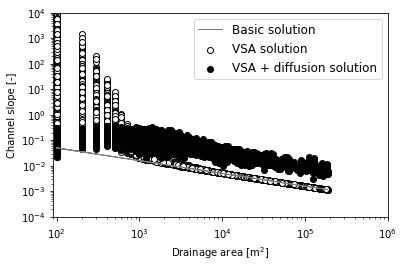

In [11]:
# MAKE SLOPE-AREA PLOT

# assign area_array and slope_array
area_array = model.grid.at_node['drainage_area'][(model.grid.node_x > 10)&(model.grid.node_x < 1580)&(model.grid.node_y >10)&(model.grid.node_y<980)]
slope_array = model.grid.at_node['topographic__steepest_slope'][(model.grid.node_x > 10)&(model.grid.node_x < 1580)&(model.grid.node_y >10)&(model.grid.node_y<980)]

# instantiate figure and plot
fig = plt.figure(figsize=(6, 3.75))
slope_area = plt.subplot()

# create an array for the detachment-limited analytical solution
u = params['outlet_lowering_rate']# m/yr, uplift or baselevel lowering rate
k = params['K_sp'] # fluvial erodibility
m = params['m_sp'] # discharge exponent
n = params['n_sp'] # slope exponent

# calculate analytical slope from area field
analytical_slope_array = np.power((u / k), 1 / n) * np.power(area_array, -m/n)

# plot the slope predicted by the effective area
slope_by_aeff = (0.0005 / 0.001) * np.power(model.eff_area, -0.5)
plt.scatter(model.grid.at_node['drainage_area'][(model.grid.node_x > 10)&(model.grid.node_x < 1580)&(model.grid.node_y >10)&(model.grid.node_y<980)], 
            slope_by_aeff[(model.grid.node_x > 10)&(model.grid.node_x < 1580)&(model.grid.node_y >10)&(model.grid.node_y<980)],
           label = 'VSA solution',
           marker='o', edgecolor='0', color='1')

# plot the data
slope_area.scatter(area_array, slope_array, marker='o', c='k', 
                   label = 'VSA + diffusion solution') 


# plot the analytical solution
slope_area.plot(area_array, analytical_slope_array, linestyle='-',
                color='grey', linewidth = 1, label = 'Basic solution')

# make axes log and set limits
slope_area.set_xscale('log')
slope_area.set_yscale('log')

slope_area.set_xlim(9*10**1, 1*10**6)
slope_area.set_ylim(1e-4, 1e4)

# set x and y labels
slope_area.set_xlabel(r'Drainage area [m$^2$]')
slope_area.set_ylabel('Channel slope [-]')

slope_area.legend(scatterpoints=1,prop={'size':12})
slope_area.tick_params(axis='x', which='major', pad=7)

# save out an output figure
output_figure = os.path.join('output_figures/maintext_vsa_slope_area.eps')
fig.savefig(output_figure, bbox_inches='tight', dpi=1000) # save figure

In [8]:
#export NetCDF for Paraview image of topography
output_file = os.path.join('output_netcdfs/maintext_vsa.nc')
write_netcdf(output_file, model.grid, format='NETCDF3_64BIT', names='topographic__elevation')

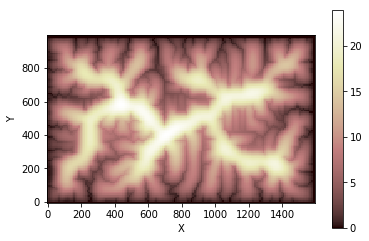

In [10]:
# make a plot of the final steady state topography
imshow_grid(model.grid, 'topographic__elevation')